In [116]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Advanced audio features
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale

**Zero-Crossing Rate**:

count how many times the signal goes from positive to negative, and from negative to positive.

Possible approach:

1. Shift the signal by one unit
2. Compare point-by-point the sign (np.sign()) of the original signal and of the shifted signal
3. Accumulate the instances of sign change

In [117]:
def zcr(input):
    return np.sum(np.abs(np.diff(np.sign(input), 1)), keepdims = True)/2

#np.sign: replaces the values with -1 if x<0, 1 if x>0 and nan for nan inputs (quick way to calculate the sign);
#np.diff: shortcut for shifting tuple elements and for comparing point-by-point (I quantify how many times the sign has changed: if there are zeros it means it has not changed, the 2 indicates that there has been a change)
#np.abs: apply absolute value; (so the information of the previous function is not lost)
#np.sum: sum (and then divide by 2); I have to divide because the output is double
#keepdims = True: to get an array as a result
#for example (10 -4 8 -2 1) = (1 -1 1 -1 1) = (-2 2 -2 2) = (8) = (8/2) = (4)

In [102]:
zcr((10,-4,8,-2,1))

array([4.])

**FEATURES (& COMBO WITH ZCR)**


In [103]:
def avg(input):
    return np.mean(input, keepdims=True)

def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

The average value of an audio signal is typically close to zero, since the signal oscillates around such value.

A more interesting feature could be the average of the absolute values (avg()).

Note: by definition, this feature is highly correlated to the "volume" of the audio track.

In [104]:
def duration(input):
    return input.shape

In [105]:
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

In [106]:
def sdev(input):
    return np.std(input, keepdims=True)

In [107]:
def combo(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input),zcr(input)))

**DATA IMPORT**

In [108]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**DATA LOADER**

1. Load the data from disk
2. Extract the class specified in the filename
3. Split audio tracks into training set and test set
4. Normalize the data using training set statistics

In [109]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

**MODEL TRAINING**

In [110]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=True)

In [111]:
# Number of training examples
len(X_train)

1350

In [112]:
# Dimensionality of the training features
X_train[0].shape

(5,)

In [113]:
# Parameters to be tested in cross-validation
param_grid = {'C': [50, 100, 250, 500, 750, 1000, 1250, 1500, 2500,2750],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 9.268s


In [114]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 2500
 gamma: 0.1


**MODEL TESTING**

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.56      0.90      0.69        10
           2       0.60      0.60      0.60        15
           3       0.85      0.58      0.69        19
           4       0.44      0.73      0.55        11
           5       0.38      0.43      0.40        14
           6       0.93      0.93      0.93        14
           7       0.89      0.42      0.57        19
           8       0.56      0.59      0.57        17
           9       0.73      0.79      0.76        14

    accuracy                           0.65       150
   macro avg       0.67      0.67      0.65       150
weighted avg       0.70      0.65      0.65       150

Confusion matrix:
[[13  0  0  0  0  1  0  0  0  3]
 [ 0  9  0  0  1  0  0  0  0  0]
 [ 0  1  9  1  1  1  1  0  1  0]
 [ 0  2  3 11  1  2  0  0  0  0]
 [ 0  1  1  0  8  1  0  0  0  0]
 [ 0  0  1  0  4  6  0  1  2  0]
 [

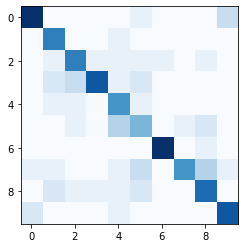

In [115]:
# Test
y_pred = clf.predict(X_test)

# Classificatioon report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

As can be seen, the optimal combination of hyper-parameters has changed, C is equal to 2500 and gamma is equal to the value of 0.1. The classification report also indicates a considerable improvement in the performance of the model due to the use of the **Zero-Crossing Rate** as a feature. In fact, despite the simplicity of this feature, the classification gains about 19% in accuracy and in weighted avg f1-score.